In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import numpy as np
from numpy.random import rand, randint, ranf, randn
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import gc
import cv2

%matplotlib inline

# データの読み込み、分割

In [2]:
PATH = '../data/training/'
ANNOTATIONS = PATH + "label_2/annotations_list.pkl"
annotations_list = pd.read_pickle("../data/training/label_2/annotations_list.pkl")
annotations_list.head()
img_list = list(annotations_list["img_name"].unique())
train_list, val_list = train_test_split(img_list, test_size=0.05, shuffle=True, random_state=0)

In [3]:
print("train_list has", len(train_list), "images.")
print("val_list has", len(val_list), "images.")

train_list has 7106 images.
val_list has 375 images.


# 学習データの作成

In [4]:
from centernet.utils import CarDataset
train_dataset = CarDataset(train_list, annotations_list, PATH, training=True)
val_dataset = CarDataset(val_list, annotations_list, PATH, training=True)

# DL Model

In [5]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
from centernet.models import MyUNet

## MyUNetの出力ベクトル長を設定
model = MyUNet(26).to(device)
model.eval()
if torch.cuda.is_available():
    model_path = "../models/model_0815_2.pth"
else:
    model_path = "../models/old/0815_batch29_val11.3151.pth"
    model_path = "../models/old/0816_batch44_val09.6579.pth"
model_path = "../models/model_cpu_41.pth"
m_state_dict = torch.load(model_path)
model.load_state_dict(m_state_dict)

Loaded pretrained weights for efficientnet-b0


<All keys matched successfully>

# Test

In [7]:
from centernet.utils import inference_heatmap, inference_2D, inference_3D

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


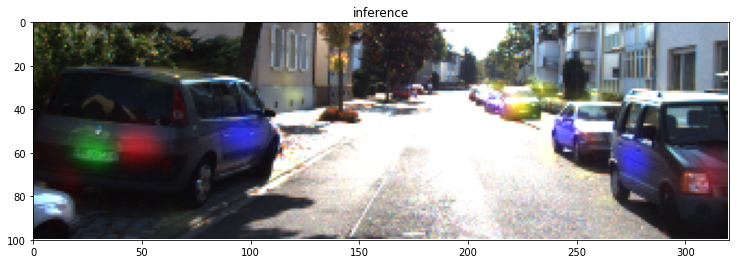

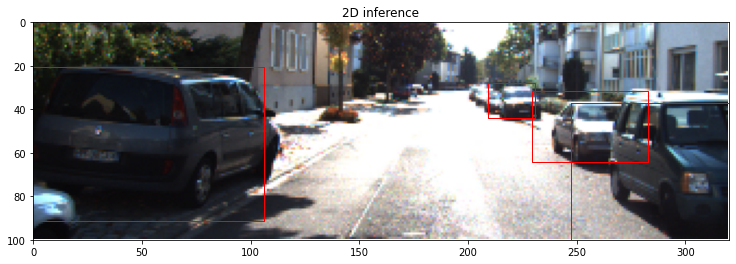

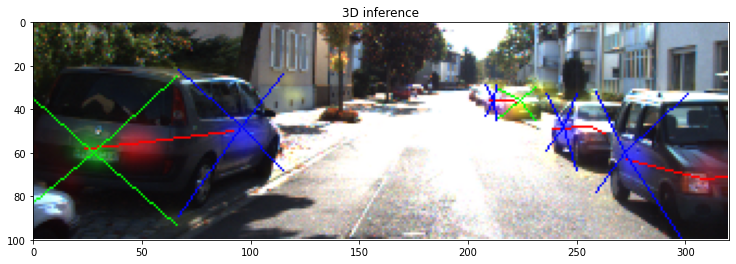

In [8]:
img, _, _, _, _ = val_dataset[0]

inference_heatmap(model, img)
inference_2D(model, img)
inference_3D(model, img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


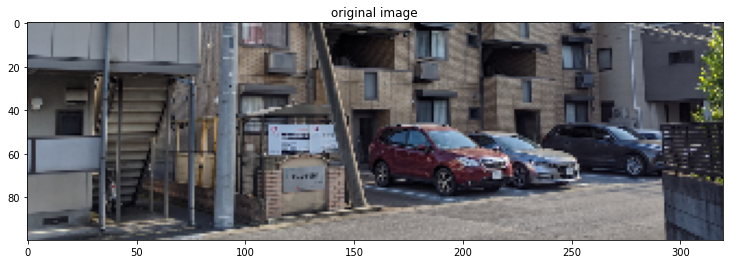

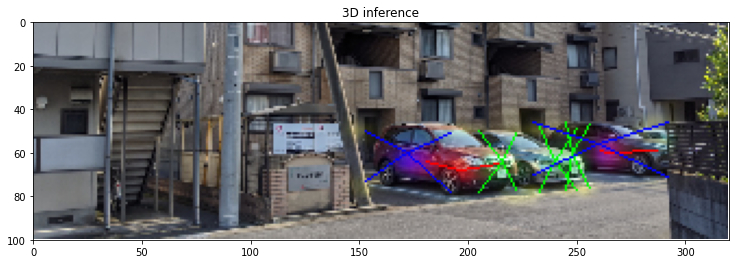

In [9]:
path = "../tmp/4.jpg"
if path[-4:]==".jpg" or path[-4:]==".JPG":
    scaled = False
elif path[-4:]==".png" or path[-4:]==".PNG":
    scaled = True

    
img = plt.imread(path)
img = cv2.resize(img, (1280//4, 400//4))
if not scaled:
    img = img/255
plt.figure(figsize=(15,4))
plt.title('original image')
plt.imshow(img)
img = np.rollaxis(img, 2, 0).astype('float32')

output = model(torch.tensor(img[None]).to(device))
logits = output.data.cpu().numpy()

inference_3D(model, img)

## movie

In [10]:
import matplotlib.image as mpimg
from IPython.display import HTML
from moviepy.editor import VideoFileClip

In [11]:
class ImgConverter():
    def __init__(self, model):
        self.model = model
        self.out_width = 320
        self.out_height = 100
        self.in_width = 1920
        self.in_height = 1080
        self.crop_top = 300
    def clip_img(self, img):
        img = img[int(self.crop_top):int(self.crop_top+self.in_width/self.out_width*self.out_height),
                  :,
                  :]
        dx = self.out_width
        dy = self.out_height
        img = cv2.resize(img, dsize=(dx,dy))
        return img
    def process_img(self, img):
        img = self.clip_img(img)
        img = np.rollaxis(img/255, 2, 0).astype('float32')
        img = inference_3D_tmp(self.model, img)
        #img = img*255
        img = np.clip(img*255,0,255)
        return img

In [12]:
from centernet.utils import inference_3D_tmp

output = '../tmp/output_video.mp4'
clip1 = VideoFileClip("../tmp/input_video.mp4")#.subclip(0,1)
imgcvt = ImgConverter(model)
clip = clip1.fl_image(imgcvt.process_img)
#%time clip.write_videofile(output, audio=False)
%time clip.write_videofile(output, audio=False)

t:   0%|          | 0/574 [00:00<?, ?it/s, now=None]

Moviepy - Building video ../tmp/output_video.mp4.
Moviepy - Writing video ../tmp/output_video.mp4



Moviepy - Done !
Moviepy - video ready ../tmp/output_video.mp4
CPU times: user 2min 28s, sys: 1.21 s, total: 2min 29s
Wall time: 47.5 s


In [13]:
HTML("""
<video width="640" height="200" controls>
  <source src="{0}">
</video>
""".format(output))